In [1]:
# Import basic packages
import os
import shutil

# Import packages for working with RGB images
import numpy as np
import cv2

# Import packages for data visualization
import matplotlib.pyplot as plt

# Import base package for working with deep learning models
import torch
import torch.nn.functional as F

# Import packages to handle loading data for training a deep learning model
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

# Import packages for data augmentations
import albumentations as albu
from torchvision import transforms as T

# Import packages containing a pre-trained segmentation models
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

# Import packages for model evaluation
from sklearn.metrics import confusion_matrix  

# Supress Warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Setting up data to train the U-Net segmentataion model
# Check if the required training, validation and testing folders exists, if not then create it

DATA_DIR = './data/'
WSIPatches_Loc = "./patches/"
MaskPatches_Loc = "./masks/"

if os.path.isdir(DATA_DIR) == False:
    os.makedirs(DATA_DIR)
    os.makedirs(DATA_DIR+'train/')
    os.makedirs(DATA_DIR+'trainannot/')

    os.makedirs(DATA_DIR+'val/')
    os.makedirs(DATA_DIR+'valannot/')

    os.makedirs(DATA_DIR+ 'test/')
    os.makedirs(DATA_DIR+ 'testannot/')
    


In [3]:
# Split patches into training/validation and test in the following ratio - 60:20:20

allFileNames = os.listdir(WSIPatches_Loc)

np.random.shuffle(allFileNames)

training = allFileNames[:int(len(allFileNames)*0.6)]
validation = allFileNames[int(len(allFileNames)*0.6):int(len(allFileNames)*0.8)]
testing = allFileNames[int(len(allFileNames)*0.8):]

for name in training:
    shutil.copy(WSIPatches_Loc+name, DATA_DIR+'train/')
    shutil.copy(MaskPatches_Loc+name, DATA_DIR+'trainannot/')

for name in validation:
    shutil.copy(WSIPatches_Loc+name, DATA_DIR+'val/')
    shutil.copy(MaskPatches_Loc+name, DATA_DIR+'valannot/')
    
for name in testing:
    shutil.copy(WSIPatches_Loc+name, DATA_DIR+'test/')
    shutil.copy(MaskPatches_Loc+name, DATA_DIR+'testannot/')


In [4]:
# Training U-NET model
# Initializing U-Net Variables

x_train_dir = os.path.join(DATA_DIR, 'train/')
y_train_dir = os.path.join(DATA_DIR, 'trainannot/')

x_valid_dir = os.path.join(DATA_DIR, 'val/')
y_valid_dir = os.path.join(DATA_DIR, 'valannot/')

x_test_dir = os.path.join(DATA_DIR, 'test/')
y_test_dir = os.path.join(DATA_DIR, 'testannot/')


In [5]:
# Helper Functions

# This function plots either a single or multiple images in the notebook output cell
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

    
# This function generates the evaluation metrics (Intersection over Union) for the segmentation model
def compute_iou(y_pred, y_true):
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [6]:
# This class arranges wsi patches and mask patches as a single unite and also performs augmentataion steps.

class Dataset(BaseDataset):
    
    CLASSES = ['tumor']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(np.invert(masks), axis=-1).astype('float')
        
        
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

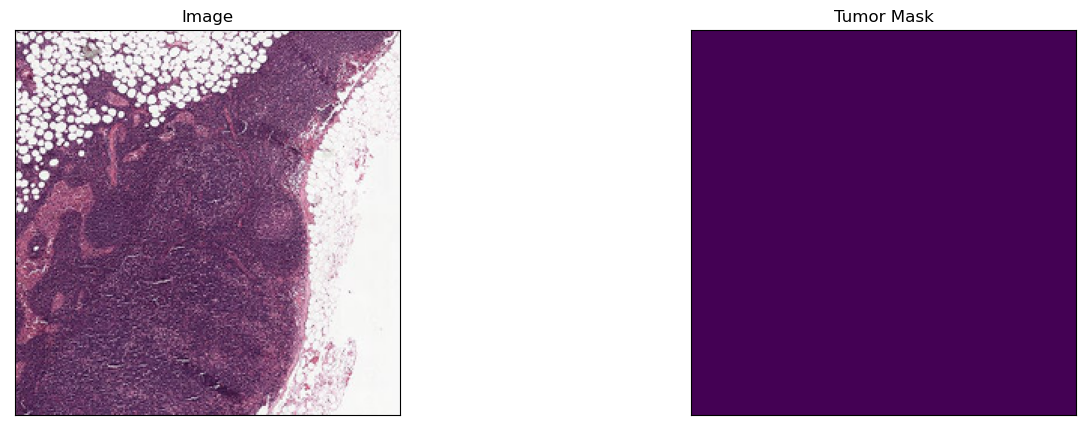

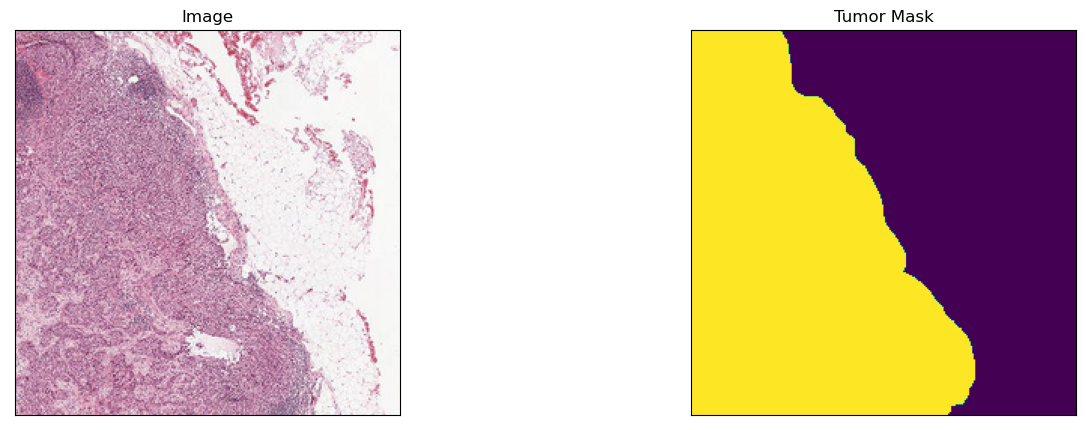

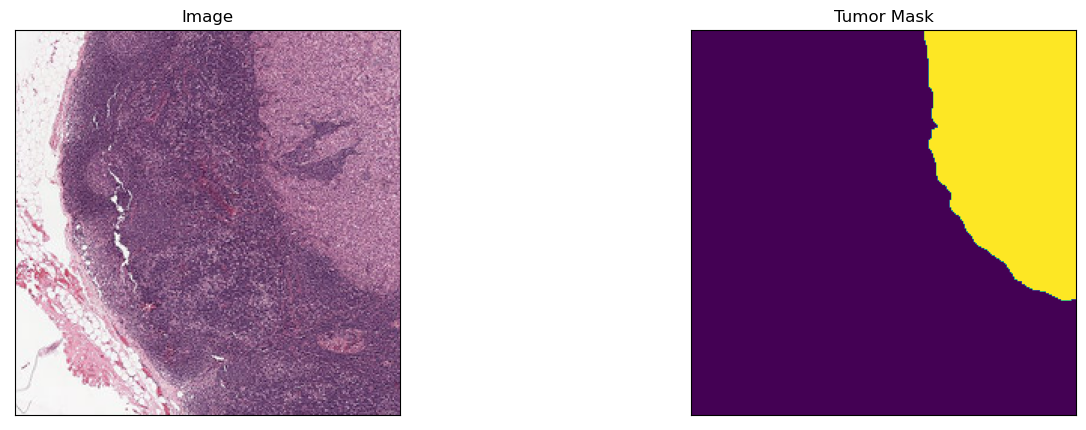

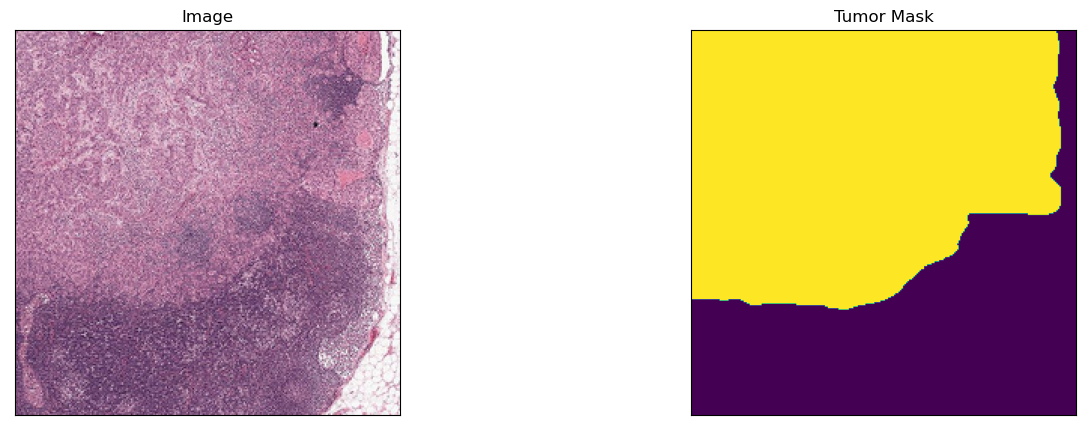

In [7]:
# Take a look at a single patch and its corresponding mask

dataset = Dataset(x_train_dir, y_train_dir, classes=['tumor'])


for i in range(4):
    image, mask = dataset[i] # get some sample
    visualize(image=image,tumor_mask=mask)



### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [8]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

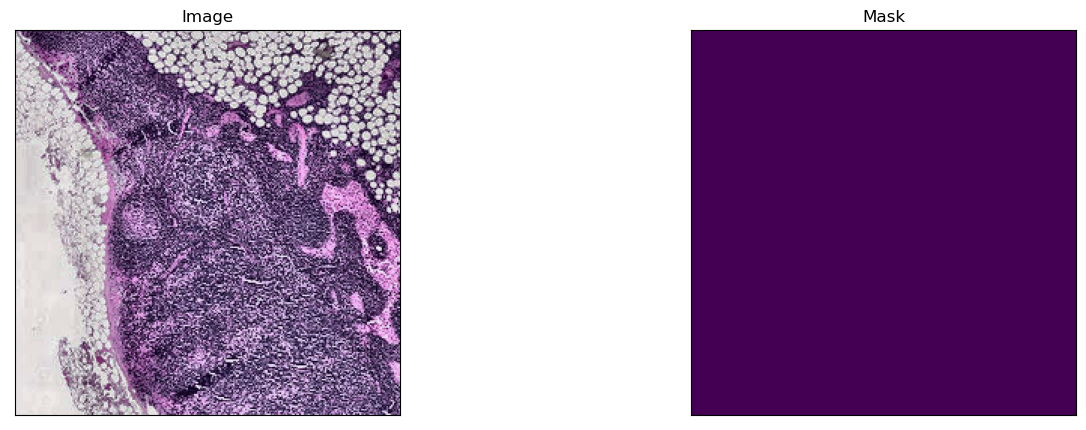

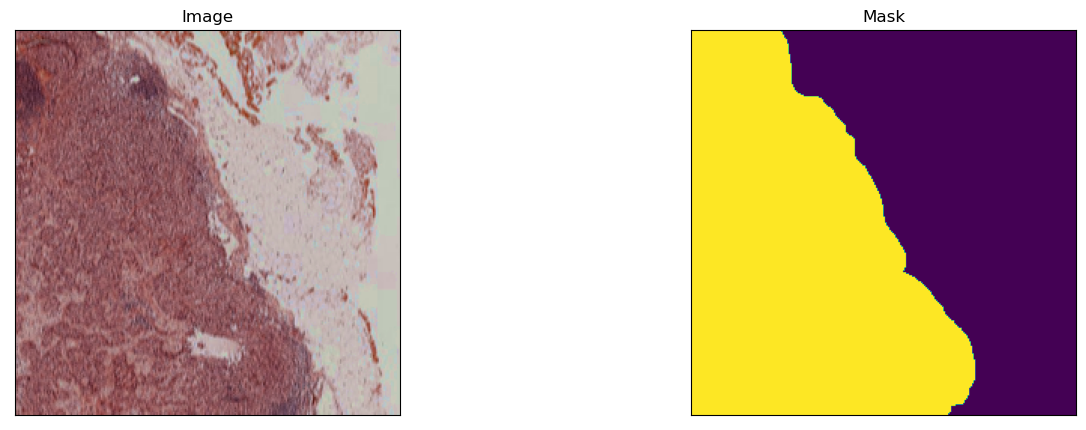

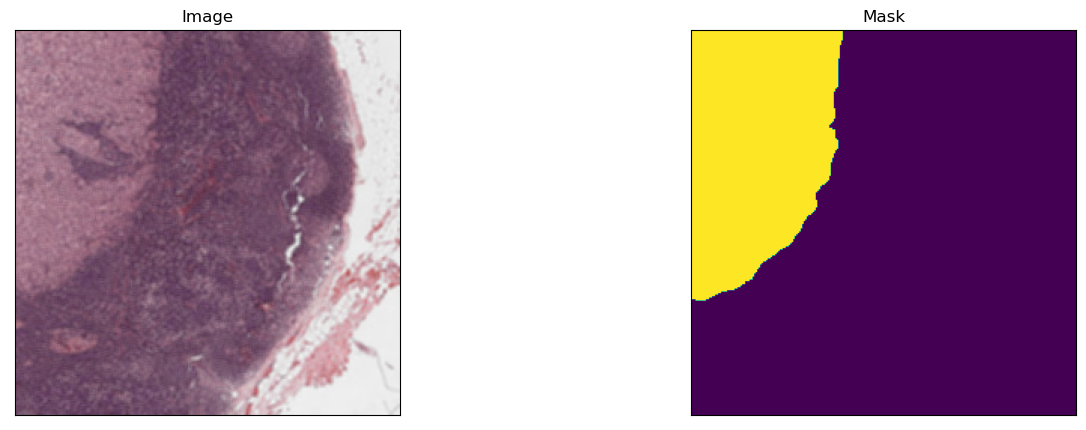

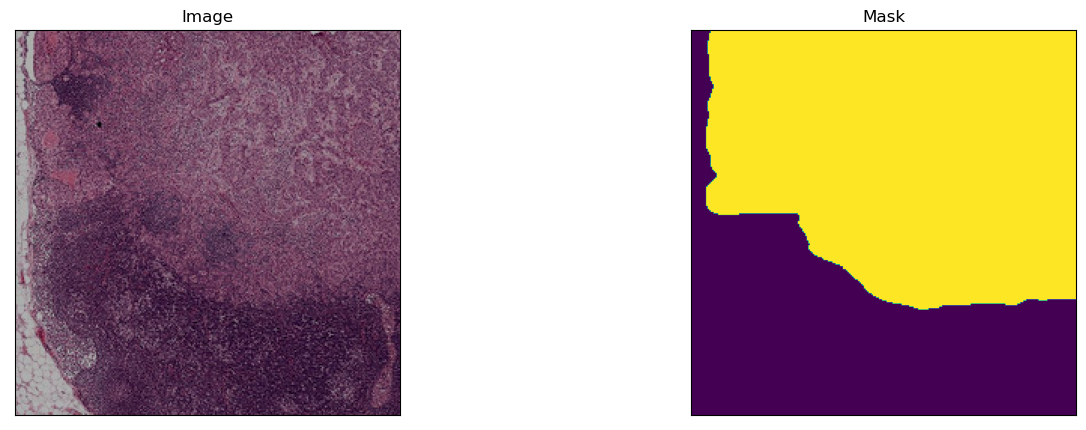

In [9]:
# Visualize resulted augmented pacthes and its corresponding masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['tumor'],
)

# same image with different random transforms
for i in range(4):
    image, mask = augmented_dataset[i]
    visualize(image=image, mask=mask)

## Create model and train

In [10]:
# Initialize parameters for the segmentation model
# RESOURCE: https://github.com/qubvel/segmentation_models.pytorch#architectures
ENCODER = 'timm-mobilenetv3_small_100'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['tumor']
ACTIVATION = 'sigmoid'
DEVICE = 'cpu'

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_small_100-37f49e2b.pth" to /home/jovyan/.cache/torch/hub/checkpoints/tf_mobilenetv3_small_100-37f49e2b.pth


  0%|          | 0.00/9.78M [00:00<?, ?B/s]

In [11]:
# Iterate through the training and validation datasets and perform augmentations

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

# Load the augmented data in batches using DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=0)

In [12]:

# Initialize loss function
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = utils.losses.DiceLoss()
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

# Initialize optimizers

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [13]:
# create epoch runners - it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [14]:
# train model for n epochs

max_score = 0

total_epochs  = 5

modelLoc = "./saved_model/" 

for i in range(0, total_epochs):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # Save the model when loss value improves
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        if os.path.isdir(modelLoc) == False:
            os.makedirs(modelLoc)
            torch.save(model, modelLoc+'best_model.pth')
        else:
            torch.save(model, modelLoc+'best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train: 100% 2/2 [00:10<00:00,  5.34s/it, dice_loss - 0.7434, iou_score - 0.1715]
valid: 100% 1/1 [00:02<00:00,  2.50s/it, dice_loss - 0.7652, iou_score - 0.04738]
Model saved!

Epoch: 1
train: 100% 2/2 [00:09<00:00,  4.75s/it, dice_loss - 0.6973, iou_score - 0.2024] 
valid: 100% 1/1 [00:01<00:00,  1.91s/it, dice_loss - 0.6906, iou_score - 0.06997]
Model saved!

Epoch: 2
train: 100% 2/2 [00:08<00:00,  4.25s/it, dice_loss - 0.6768, iou_score - 0.2395]
valid: 100% 1/1 [00:01<00:00,  1.31s/it, dice_loss - 0.65, iou_score - 0.1167]
Model saved!

Epoch: 3
train: 100% 2/2 [00:07<00:00,  3.68s/it, dice_loss - 0.6889, iou_score - 0.2329]
valid: 100% 1/1 [00:01<00:00,  1.90s/it, dice_loss - 0.6209, iou_score - 0.1699]
Model saved!

Epoch: 4
train: 100% 2/2 [00:08<00:00,  4.10s/it, dice_loss - 0.643, iou_score - 0.2707] 
valid: 100% 1/1 [00:01<00:00,  1.90s/it, dice_loss - 0.597, iou_score - 0.2259]
Model saved!


## Test best saved model

In [15]:
# load best saved checkpoint
best_model = torch.load(modelLoc+'best_model.pth')

In [16]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir,  
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [17]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100% 3/3 [00:01<00:00,  1.57it/s, dice_loss - 0.7182, iou_score - 0.1659]


## Visualize predictions using  Intersection Over Union (IoU)

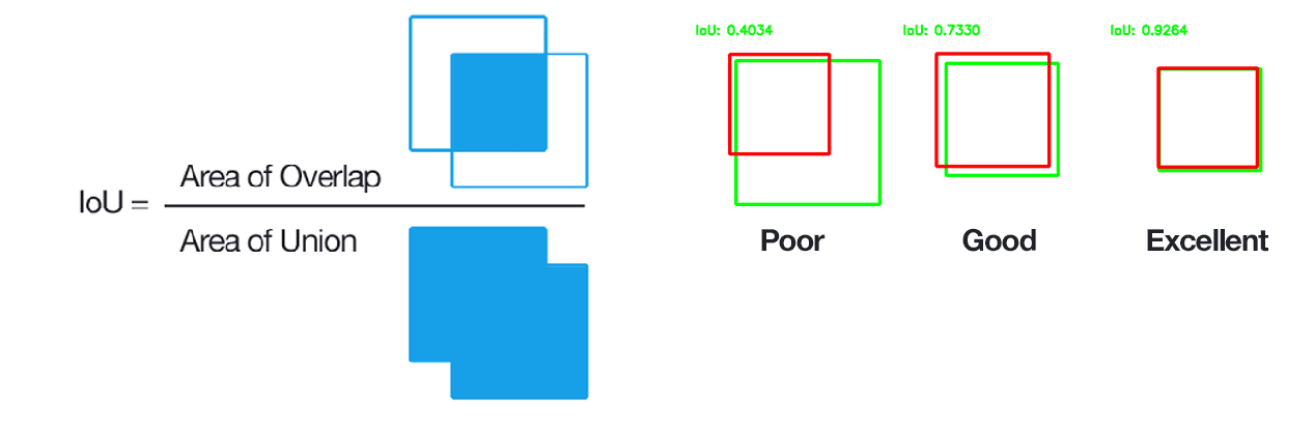

In [18]:
# Test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

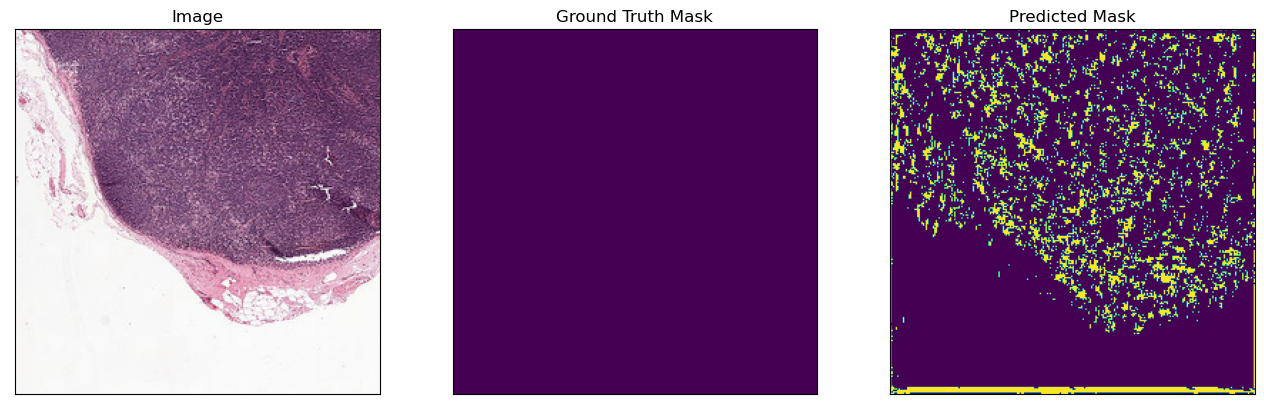

-----------------------------
IoU: 0.42755889892578125
-----------------------------


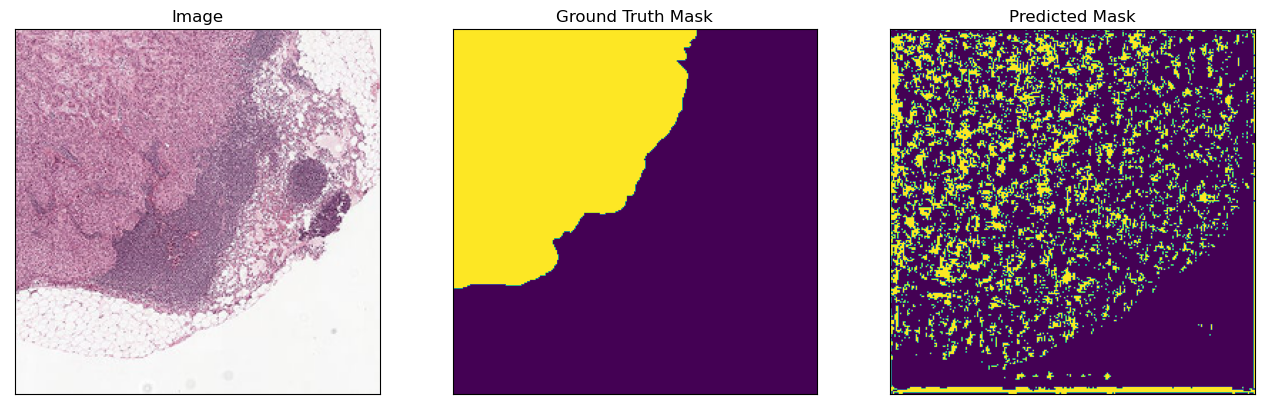

-----------------------------
IoU: 0.43191442428557386
-----------------------------


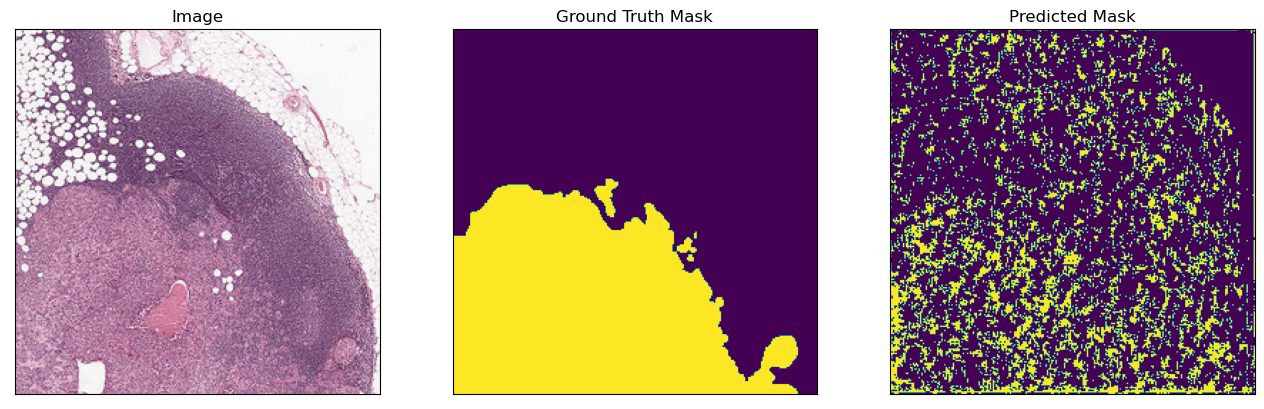

-----------------------------
IoU: 0.41580946736863544
-----------------------------


In [20]:
# Visualize predictions on images from the test dataset

for i in range(3):
    
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    score = compute_iou(pr_mask, gt_mask)
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )
    
    print("-----------------------------")
    print("IoU: "+str(score))
    print("-----------------------------")

In [ ]:
#--------------------------------------------End of Coding Session 2-----------------------------------------------------------#